### <b>Summary</b>
In this notebook, I want to predict abstractive summaries using body texts of research papers. I divide my dataset into 80-20 training-test dataset. I use BERT-Base uncased and [BertAbs](https://github.com/nlpyang/PreSumm) model to train the data. Since, BERT only allows 512 tokens as the input, I perform extractive summarization using TextRank on the text to get 500 word length summaries. I then train my model on these summaries to obtain abstractive summaries. I evaluate my model using rouge score of predicted summaries against abstracts. I 


##### BertAbs parameters
 - Encoder is pretrained [BERTSUM](https://arxiv.org/pdf/1903.10318.pdf) model
 - Decoder is a 6 layered Transformer initialized randomly
 - Two Adam optimizers (0.9, 0.999) are used for the encoder and decoder seperately. This is because the encoder is pretrained while decoder is not. This can make fine-tuning unstable.
 - learning rate for encoder is 0.002 and decoder is 0.1 because the encoder (which is pretrained) needs to be fine-tuned at a smaller rate. 
 - model is trained for total 100,000 steps and checkppoints are saved every 10,000 steps
 
#### <b>Observations</b>
The rouge score after 200,000 steps
ROUGE-F(1/2/3/l): 31.81/11.30/19.66
ROUGE-R(1/2/3/l): 23.41/8.42/14.56

Looking at the rouge score, the model isn't performing super well. This maybe due to the fact that predicted extracted summaries itself have a lower rouge score against abstracts.
Some predicted summaries are exactly similar to their bodytext. This could be due to the model being trained on some papers that have same abstract and bodytext.

#### <b>Future Enhancements</b>
Run the model for different learning rates.
Remove papers with same abstracts and bodytext to train the model on good data
Use a different extractive summarization model


In [ ]:
import glob
import json
import pandas as pd
import os
import spacy
import re
import string
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from langdetect import detect
import itertools
from numba import jit, cuda
from summa import summarizer
from rouge import Rouge

## Data loading and cleaning
   1. Load papers into a dataframe.
   2. Filter papers without an abstract or body text.
   3. Filter non-english papers.

In [2]:
%%time

path = '/home/ubuntu/data/*.json'
files = glob.glob(path)
papers = []
for file in files:
    with open(file) as json_file:
            text = json.load(json_file)
            papers.append([text['paper_id'], text['bodytext'], text['abstract']])
data = pd.DataFrame(papers, columns = ['paper_id', 'bodytext', 'abstract'])

#get the lengths of texts
data['len_bt'] = data.bodytext.map(lambda x: len(x.split(" ")))
data['len_ab'] = data.abstract.map(lambda x: len(x.split(" ")))

#filter papers with certain word length
data.query('len_bt <= 10000 and len_bt>=1000 and len_ab <= 500 and len_ab >=100', inplace = True)

#detect languages of texts to filter out non-english papers
data['bt_lang'] = data.bodytext.map(lambda x: detect(x))
data['ab_lang'] = data.abstract.map(lambda x: detect(x))

#use only english papers
data = data[(data['bt_lang'] == 'en') & (data['ab_lang'] == 'en')]

CPU times: user 6min 8s, sys: 1.93 s, total: 6min 10s
Wall time: 6min 10s


In [3]:
data.dtypes

paper_id    object
bodytext    object
abstract    object
len_bt       int64
len_ab       int64
bt_lang     object
ab_lang     object
dtype: object

In [4]:
data["textrank_summary"]=data.apply(lambda x: summarizer.summarize(str(x.bodytext), words = x.len_ab), axis = 1)
data[:2]

,paper_id,bodytext,abstract,len_bt,len_ab,bt_lang,ab_lang,textrank_summary
3,5da136317f5b97ed8371d5121d8828f1c9a5372d,Malaria is a mosquito-borne infectious parasi...,"Background: Congenital malaria, in which infa...",3088,331,en,en,Cases of congenital malaria reported in Englis...
4,8befdc2bb43130a5e90c11061e8bc8955718a825,"In 2003, the world was struck by the epidemic...","Background: Following the SARS outbreak, the ...",4865,339,en,en,A health communication capacity building proje...


In [6]:
data = data[data.textrank_summary!= ""]

In [7]:
def cal_rougescore(row,metric, measure):
    if row.textrank_summary == "":
        return 0
    else:
        return evaluator.get_scores(str(row.textrank_summary), str(row.abstract))[0][metric][measure]

In [8]:
evaluator = Rouge()
#,data["rouge_2"],data["rouge-l"]  
data["rouge_1_f"]= data.apply(lambda x: cal_rougescore(x, 'rouge-1', 'f'), axis = 1)
data["rouge_2_f"]= data.apply(lambda x: cal_rougescore(x, 'rouge-2', 'f'), axis = 1)
data["rouge_l_f"]= data.apply(lambda x: cal_rougescore(x, 'rouge-l', 'f'), axis = 1)

data["rouge_1_p"]= data.apply(lambda x: cal_rougescore(x, 'rouge-1', 'p'), axis = 1)
data["rouge_2_p"]= data.apply(lambda x: cal_rougescore(x, 'rouge-2', 'p'), axis = 1)
data["rouge_l_p"]= data.apply(lambda x: cal_rougescore(x, 'rouge-l', 'p'), axis = 1)

data["rouge_1_r"]= data.apply(lambda x: cal_rougescore(x, 'rouge-1', 'r'), axis = 1)
data["rouge_2_r"]= data.apply(lambda x: cal_rougescore(x, 'rouge-2', 'r'), axis = 1)
data["rouge_l_r"]= data.apply(lambda x: cal_rougescore(x, 'rouge-l', 'r'), axis = 1)

In [9]:
data["textrank_summary"]=data.textrank_summary.str.replace('\n',"")

Text(0.5, 0, 'abstract length')

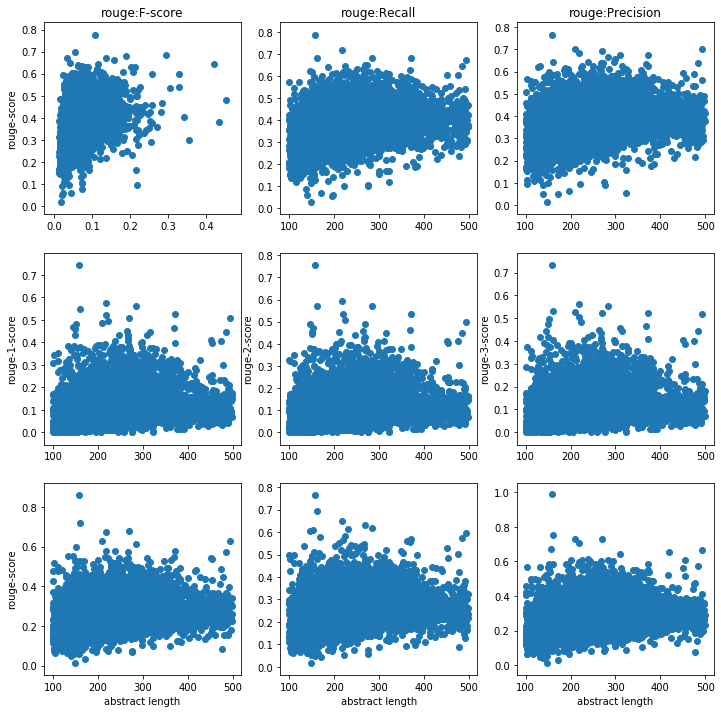

In [10]:
plt.figure(figsize = (12,12))
plt.subplot(3, 3, 1)
plt.scatter(data.len_ab/data.len_bt, data.rouge_1_f)
#plt.line(data.length_abstract, np.mean(data.rouge_1_f), linestyle = '--')
plt.title('rouge:F-score')
plt.ylabel('rouge-score')

#plt.xlabel('abstract length')

plt.subplot(3, 3, 2)
plt.scatter(data.len_ab, data.rouge_1_r)
plt.title('rouge:Recall')
#plt.ylabel('rouge-score')
#plt.xlabel('abstract length')

plt.subplot(3, 3, 3)
plt.scatter(data.len_ab, data.rouge_1_p)
plt.title('rouge:Precision')
#plt.ylabel('rouge-score')
#plt.xlabel('abstract length')

plt.subplot(3, 3, 4)
plt.scatter(data.len_ab, data.rouge_2_f)
#plt.title('rouge-2:F-score')
plt.ylabel('rouge-1-score')
#plt.xlabel('abstract length')

plt.subplot(3, 3, 5)
plt.scatter(data.len_ab, data.rouge_2_r)
#plt.title('rouge-2:F-score')
plt.ylabel('rouge-2-score')
#plt.xlabel('abstract length')

plt.subplot(3, 3, 6)
plt.scatter(data.len_ab, data.rouge_2_p)
#plt.title('rouge-3:F-score')
plt.ylabel('rouge-3-score')
#plt.xlabel('abstract length')

plt.subplot(3, 3, 7)
plt.scatter(data.len_ab, data.rouge_l_f)
#plt.title('rouge-l:F-score')
plt.ylabel('rouge-score')
plt.xlabel('abstract length')

plt.subplot(3, 3, 8)
plt.scatter(data.len_ab, data.rouge_l_r)
#plt.title('rouge-l:F-score')
#plt.ylabel('rouge-score')
plt.xlabel('abstract length')

plt.subplot(3, 3, 9)
plt.scatter(data.len_ab, data.rouge_l_p)
#plt.title('rouge-l:F-score')
#plt.ylabel('rouge-score')
plt.xlabel('abstract length')

In [11]:
data.rouge_1_f.describe()

count    7372.000000
mean        0.384835
std         0.081081
min         0.018957
25%         0.330739
50%         0.387165
75%         0.439119
max         0.776758
Name: rouge_1_f, dtype: float64

#### Split the data into train and test datasets

In [12]:
train, test = train_test_split(data, test_size = 0.2, random_state = 42)
train = train.reset_index()
test = test.reset_index()
len(train), len(test)

(5897, 1475)

#### Since BERT base model only takes 512 tokens and the text length of our papers is greater than that, extractive summaries limited to word length 500 are obtained using summa package. 
#### These summaries are written in files and are given as input to the BertAbs model. 

In [13]:
import os
def create_story_files(df,num_file,corpus_type,filename=None):
    for i in range(num_file):
        doc = df.iloc[i]['bodytext'] + '\n'*2 + '@abstract' + '\n'*2 + df.iloc[i]['abstract']
        file_name = os.path.join(filename,('paper_' + corpus_type + '_' + str(i) + '.story'))
        #print(file_name)
        with open(file_name,'w+') as story_file:
            story_file.write(doc)

def create_ext_summary_files(df,num_file,corpus_type,filename=None):
    for i in range(num_file):
        ext_text = summarizer.summarize(df.iloc[i]['bodytext'], words = 500)
        ext_text = ext_text.replace('\n', '')
        doc = ext_text + '\n'*2 + '@abstract' + '\n'*2 + df.iloc[i]['abstract']
        #print(doc)
        file_name = os.path.join(filename,('paper_' + corpus_type + '_' + str(i) + '.story'))
        with open(file_name,'w+') as story_file:
            story_file.write(doc)


In [14]:
n_train = len(train)
n_test = len(test)
# create_story_files(train,n_train,cip-172-31-14-178orpus_type='train',filename='/home/ubuntu/BERT/covid_data')
# create_story_files(test,n_test,corpus_type = 'test',filename='/home/ubuntu/BERT/covid_data')

create_ext_summary_files(train,n_train,corpus_type='train',filename='/home/ubuntu/BERT/covid_extracted_summaries')
create_ext_summary_files(test,n_test,corpus_type = 'test',filename='/home/ubuntu/BERT/covid_extracted_summaries')

#### The extracted summaries are pre-processed by splitting sentences and tokenization and stored in seperate json files.

In [15]:
os.chdir("/home/ubuntu/stanford-corenlp-full-2017-06-09")
os.getcwd()
!python /home/ubuntu/PreSumm/src/preprocess.py -mode tokenize -raw_path /home/ubuntu/BERT/covid_extracted_summaries -save_path /home/ubuntu/BERT/merged_stories_tokenized  -log_file /home/ubuntu/BERT/logs/covid.log
os.chdir("/home/ubuntu/")
os.getcwd()

Making list of files to tokenize...
Tokenizing 7961 files in /home/ubuntu/BERT/covid_extracted_summaries and saving in /home/ubuntu/BERT/merged_stories_tokenized...
-----------------------------1--------------------
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator tokenize
[main] INFO edu.stanford.nlp.pipeline.TokenizerAnnotator - No tokenizer type provided. Defaulting to PTBTokenizer.
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ssplit

Processing file /home/ubuntu/BERT/covid_extracted_summaries/paper_test_959.story ... writing to /home/ubuntu/BERT/merged_stories_tokenized/paper_test_959.story.json
Annotating file /home/ubuntu/BERT/covid_extracted_summaries/paper_test_959.story ... done [0.1 sec].
Processing file /home/ubuntu/BERT/covid_extracted_summaries/paper_train_3527.story ... writing to /home/ubuntu/BERT/merged_stories_tokenized/paper_train_3527.story.json
Annotating file /home/ubuntu/BERT/covid_extracted_summaries/paper_train

'/home/ubuntu'

#### The tokens in json files are divided into source (body text) and target tokens (abstract) and combined into a single json file each for train and test dataset. 

In [16]:
!python /home/ubuntu/PreSumm/src/preprocess.py -mode custom_format_to_lines -raw_path /home/ubuntu/BERT/merged_stories_tokenized -save_path /home/ubuntu/BERT/json_data/covid_data -n_cpus 1 -use_bert_basic_tokenizer false -log_file /home/ubuntu/BERT/logs/covid.log

#### Further pre-processing steps are applied to the text and saved in a PyTorch file
 - Three special tokens, [CLS] at the beginning of a text and [SEP] at the end of every sentence and [PAD] for padding are added.
 - Token, segmentation and position embeddings are added. 

In [17]:
!python /home/ubuntu/PreSumm/src/preprocess.py -mode custom_format_to_bert -raw_path /home/ubuntu/BERT/json_data/ -save_path /home/ubuntu/BERT/covid_bert_data  -lower -n_cpus 1 -log_file /home/ubuntu/BERT/logs/cnndm.log 

#### BertAbs model is trained
 - Encoder is pretrained [BERTSUM](https://arxiv.org/pdf/1903.10318.pdf) model
 - Decoder is a 6 layered Transformer initialized randomly
 - Two Adam optimizers (0.9, 0.999) are used for the encoder and decoder seperately. This is because the encoder is pretrained while decoder is not. This can make fine-tuning unstable.
 - learning rate for encoder is 0.002 and decoder is 0.1 because the encoder (which is pretrained) needs to fine-tuned at a smaller rate. 
 - model is trained for total 100,000 steps and checkppoints are saved every 10,000 steps

In [1]:
!python ~/PreSumm/src/train.py  -task abs -mode train -train_from ~/BERT/model_step_110000.pt -bert_data_path ~/BERT/covid_bert_data/covid_data -dec_dropout 0.2  -model_path ~/BERT -sep_optim true -lr_bert 0.002 -lr_dec 0.2 -save_checkpoint_steps 10000 -batch_size 140 -train_steps 200000 -report_every 10000 -accum_count 5 -use_bert_emb true -use_interval true -warmup_steps_bert 20000 -warmup_steps_dec 10000 -max_pos 500 -visible_gpus 0  -log_file /home/ubuntu/BERT/logs/abs_bert_covid

[2021-02-26 03:49:52,245 INFO] Namespace(accum_count=5, alpha=0.6, batch_size=140, beam_size=5, bert_data_path='/home/ubuntu/BERT/covid_bert_data/covid_data', beta1=0.9, beta2=0.999, block_trigram=True, dec_dropout=0.2, dec_ff_size=2048, dec_heads=8, dec_hidden_size=768, dec_layers=6, enc_dropout=0.2, enc_ff_size=512, enc_hidden_size=512, enc_layers=6, encoder='bert', ext_dropout=0.2, ext_ff_size=2048, ext_heads=8, ext_hidden_size=768, ext_layers=2, finetune_bert=True, generator_shard_size=32, gpu_ranks=[0], label_smoothing=0.1, large=False, load_from_extractive='', log_file='/home/ubuntu/BERT/logs/abs_bert_covid', lr=1, lr_bert=0.002, lr_dec=0.2, max_grad_norm=0, max_length=150, max_pos=500, max_tgt_len=140, min_length=15, mode='train', model_path='/home/ubuntu/BERT', optim='adam', param_init=0, param_init_glorot=True, recall_eval=False, report_every=10000, report_rouge=True, result_path='../results/cnndm', save_checkpoint_steps=10000, seed=666, sep_optim=True, share_emb=False, task='

In [ ]:
#### model is tested on the test dataset and rouge scores are calculated
The rouge score at 200,000 step
ROUGE-F(1/2/3/l): 31.81/11.30/19.66
ROUGE-R(1/2/3/l): 23.41/8.42/14.56
    
The average rouge scores (not multiplied by 100)
1 ROUGE-1 Average_R: 0.23387 (95%-conf.int. 0.22851 - 0.23929)
1 ROUGE-1 Average_P: 0.55938 (95%-conf.int. 0.55177 - 0.56766)
1 ROUGE-1 Average_F: 0.31751 (95%-conf.int. 0.31193 - 0.32307)
---------------------------------------------
1 ROUGE-2 Average_R: 0.08276 (95%-conf.int. 0.07690 - 0.08891)
1 ROUGE-2 Average_P: 0.19158 (95%-conf.int. 0.18100 - 0.20313)
1 ROUGE-2 Average_F: 0.11114 (95%-conf.int. 0.10415 - 0.11878)
---------------------------------------------
1 ROUGE-L Average_R: 0.14536 (95%-conf.int. 0.13979 - 0.15079)
1 ROUGE-L Average_P: 0.34288 (95%-conf.int. 0.33401 - 0.35262)
1 ROUGE-L Average_F: 0.19612 (95%-conf.int. 0.18993 - 0.20263)
    
The predicted and candidate summaries are stored in text file.


In [2]:
!python ~/PreSumm/src/train.py -task abs -mode test -model_path ~/BERT -test_from ~/BERT/model_step_200000.pt -batch_size 100 -test_batch_size 100 -bert_data_path ~/BERT/covid_bert_data/covid_data -temp_dir ~/BERT/temp -log_file ~/BERT/logs/abs_bert_covid  -sep_optim true -use_interval true -visible_gpus 0 -max_pos 512 -max_length 200 -alpha 0.82 -min_length 10 -result_path ~/BERT/logs/abs_bert_covid

[2021-02-28 03:41:39,258 INFO] Loading checkpoint from /home/ubuntu/BERT/model_step_200000.pt
Namespace(accum_count=1, alpha=0.82, batch_size=100, beam_size=5, bert_data_path='/home/ubuntu/BERT/covid_bert_data/covid_data', beta1=0.9, beta2=0.999, block_trigram=True, dec_dropout=0.2, dec_ff_size=2048, dec_heads=8, dec_hidden_size=768, dec_layers=6, enc_dropout=0.2, enc_ff_size=512, enc_hidden_size=512, enc_layers=6, encoder='bert', ext_dropout=0.2, ext_ff_size=2048, ext_heads=8, ext_hidden_size=768, ext_layers=2, finetune_bert=True, generator_shard_size=32, gpu_ranks=[0], label_smoothing=0.1, large=False, load_from_extractive='', log_file='/home/ubuntu/BERT/logs/abs_bert_covid', lr=1, lr_bert=0.002, lr_dec=0.002, max_grad_norm=0, max_length=200, max_pos=512, max_tgt_len=140, min_length=10, mode='test', model_path='/home/ubuntu/BERT', optim='adam', param_init=0, param_init_glorot=True, recall_eval=False, report_every=1, report_rouge=True, result_path='/home/ubuntu/BERT/logs/abs_bert_covi

#### Print predicted summaries
#### The predicted summaries contain important words from the actual abstracts

In [3]:
with open('/home/ubuntu/BERT/logs/abs_bert_covid.200000.gold','r') as s:
    summary = s.readlines()

for i in range(2):
    print(summary[i])

respiratory viral infections can trigger asthma attack which may lead to sever morbidity . in this report , using molecular methods , we show the chronological association between human coronavirus - hku1 infection and asthma exacerbation in a two years and seven months old asthmatic girl who was not under treatment and was otherwise healthy .

the ebola virus disease outbreak in west africa has prompted significant progress in responding to the clinical needs of patients affected by emerging infectious disease outbreaks . among the noteworthy successes of vaccine trials , and the commendable efforts to implement clinical treatment trials during ebola outbreaks , we should also focus on strengthening the collection and curation of epidemiological and observational data that can improve the conception and design of clinical research .



#### Print abstracts from papers

In [4]:
with open('/home/ubuntu/BERT/logs/abs_bert_covid.200000.candidate','r') as s:
    cand = s.readlines()

for i in range(2):
    print(cand[i])

respiratory viral infections can trigger asthma attack which may lead to sever morbidity . in this report , using molecular methods , we show the chronological association between human coronavirus - hku1 infection and asthma exacerbation in a two years and seven months old asthmatic girl who was not under treatment and was otherwise healthy .

background : there is a growing number of highly pathogenic avian influenza ( evd ) infectious diseases that have caused multiple outbreaks in the republic of congo between 2013 and 2013 . the world health organization ( who ) , for at the ever-evd outbreak , there is still a paucity of datasets that can be tested with evd and other pathogens . this review summarizes the current state of current global datasets , and assess the performance of key treatments for each of these pathogen . methods/priority pandemic and vaccines are critical to assess the burden of evd and vaccines . this article reviews the current status of these centers for diseas